<a href="https://colab.research.google.com/github/Piyushiitk24/dc_motor_parameter_estimation/blob/main/megastair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# requirements
!pip install pandas numpy matplotlib scipy

Skipping step 4 due to poor fit: 32.5%
Individual Step Results:
Step | Start Time | ΔU | U | ΔU_eff | Y0 | Y_ss | K | τ | Fit% | Direction
   1 |     39.00 | 6.00 | 6.00 |   1.50 | 70.3 | 135.9 | 43.73 | 0.33 | 94.4 | up
   2 |     42.00 | 2.00 | 8.00 |   2.00 | 134.2 | 205.0 | 35.13 | 0.20 | 92.5 | up
   3 |     45.00 | 0.81 | 8.81 |   0.81 | 211.5 | 228.4 | 21.21 | 0.37 | 92.1 | up
   4 |     57.00 | -6.00 | -6.00 |  -1.50 | -84.2 | -148.2 | 43.95 | 0.30 | 91.8 | down
   5 |     60.00 | -2.00 | -8.00 |  -2.00 | -150.3 | -217.5 | 33.23 | 0.19 | 90.4 | down
   6 |     63.00 | -0.81 | -8.81 |  -0.81 | -221.4 | -240.3 | 22.57 | 0.21 | 70.7 | down

Overall (Average all): K = 33.3044, τ = 0.2652
Up steps (Average): K = 33.3568, τ = 0.3000
Down steps (Average): K = 33.2520, τ = 0.2305

Overall Transfer Function: 33.3044 / (0.2652 s + 1)

Comparison Table:
 step_num       K    tau  fit_pct direction     u  delta_u_eff
        1 43.7312 0.3302  94.3739        up  6.00         1.50
        2 3

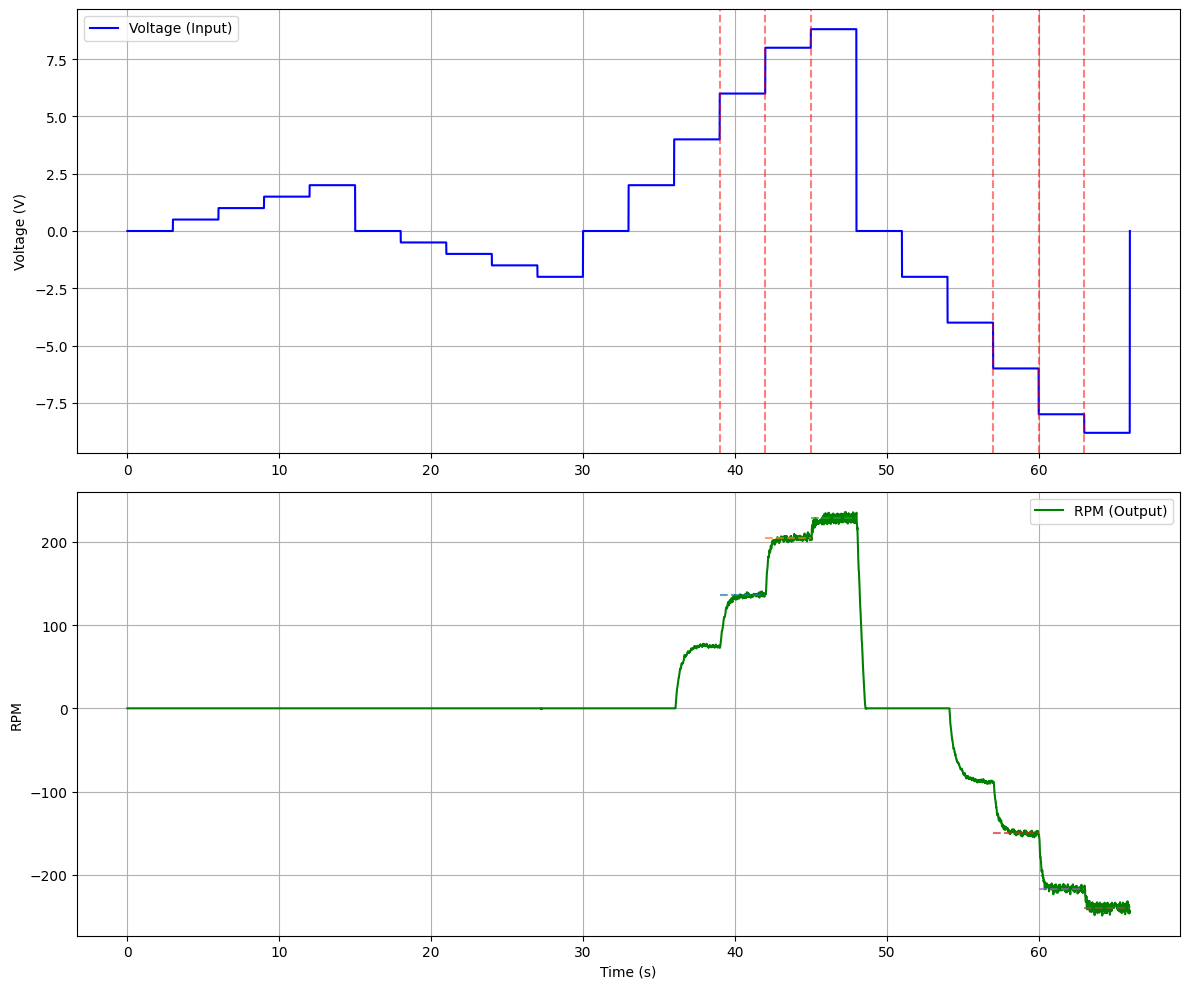


Results saved to 'step_fits.csv'


In [13]:
# Full Corrected Script for Step-by-Step System Identification
# Run in Colab: Add %matplotlib inline at top if needed.
# Changes: Ensured start/end indices stored; lowered fit% to 60% to include small steps; coast-down skipped via delta_y <5 RPM.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.signal import savgol_filter

# Read the CSV file (upload 'run_minimal.csv' to Colab if needed)
df = pd.read_csv('run_minimal.csv')

# Ensure columns are correctly typed
df['time'] = pd.to_numeric(df['time'], errors='coerce')
df['voltage'] = pd.to_numeric(df['voltage'], errors='coerce')
df['rpm'] = pd.to_numeric(df['rpm'], errors='coerce')

# Deadband compensation (VDB=4.5V)
VDB = 4.5
def eff(v):  # u_eff
    return np.sign(v) * np.maximum(np.abs(v) - VDB, 0.0)

df["u_eff"] = eff(df["voltage"].values)

# Smooth RPM for identification (keep raw for plots)
y_raw = df['rpm'].values
y_id  = savgol_filter(y_raw, window_length=51, polyorder=2, mode='interp')  # ~0.5 s at 100 Hz
df['rpm_id'] = y_id  # Add to df for convenience

# Robust edge threshold on u_eff
du_eff = np.diff(df["u_eff"].values, prepend=df["u_eff"].values[0])
thrV = max(0.2, 4.0 * stats.median_abs_deviation(np.diff(df["u_eff"].values), scale='normal'))
changes = [0] + [i for i in range(1, len(df)) if abs(df["u_eff"].iloc[i] - df["u_eff"].iloc[i-1]) >= thrV] + [len(df)]

# Minimum requirements
MIN_DVEFF  = 0.5    # V, after deadband compensation
MIN_DWELLN = int(2.0 / 0.01)  # at least 2 s if Ts=0.01

# List to store results for each step
step_results = []

# Overall plot setup (use raw RPM)
fig_overall, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
ax1.plot(df['time'], df['voltage'], label='Voltage (Input)', color='blue')
ax1.set_ylabel('Voltage (V)')
ax1.legend()
ax1.grid(True)

ax2.plot(df['time'], y_raw, label='RPM (Output)', color='green')
ax2.set_ylabel('RPM')
ax2.set_xlabel('Time (s)')
ax2.legend()
ax2.grid(True)

# Function for first-order step response model
def step_model(t, delta_y, tau):
    return delta_y * (1 - np.exp(-t / tau))

# Fit quality metric
def fitpct(y, yhat):
    denom = np.linalg.norm(y - np.mean(y))
    if denom < 1e-6: return np.nan
    return 100.0 * (1.0 - np.linalg.norm(y - yhat)/(denom + 1e-12))

# Process each segment (step)
prev_u = df['voltage'].iloc[0]
prev_ue = eff(prev_u)
for seg in range(len(changes) - 1):
    start_idx = changes[seg]
    end_idx = changes[seg + 1] - 1

    if start_idx > end_idx:
        continue

    seg_df = df.iloc[start_idx:end_idx + 1].copy()
    t_start = seg_df['time'].iloc[0]
    t_seg = seg_df['time'] - t_start
    u = seg_df['voltage'].iloc[0]
    ue = seg_df['u_eff'].iloc[0]
    delta_u_eff = ue - prev_ue

    # Require enough dwell and meaningful effective step
    if len(seg_df) < MIN_DWELLN:
        prev_u = u
        prev_ue = ue
        continue
    if abs(delta_u_eff) < MIN_DVEFF:
        prev_u = u
        prev_ue = ue
        continue

    # Adaptive smoothing: Larger window for small steps (noisy)
    window_len = 101 if abs(delta_u_eff) < 1.0 else 51
    y = savgol_filter(y_raw[start_idx:end_idx + 1], window_length=window_len, polyorder=2, mode='interp')
    y0 = y[0]
    y_ss_approx = y[-1]
    delta_y_guess = y_ss_approx - y0
    if abs(delta_y_guess) < 5:  # flat/no info → skip (this skips coast-down)
        prev_u = u
        prev_ue = ue
        continue

    # Bounds + initial guess
    tau0 = max(0.05, min(2.0, (seg_df['time'].iloc[-1] - seg_df['time'].iloc[0]) / 3.0))
    p0 = [delta_y_guess, tau0]
    lb_tau, ub_tau = 0.02, 5.0
    if delta_y_guess >= 0:
        lb_dy, ub_dy = 0.3 * delta_y_guess, 1.7 * delta_y_guess
    else:
        lb_dy, ub_dy = 1.7 * delta_y_guess, 0.3 * delta_y_guess

    # Fit
    try: # Added colon here
        popt, _ = curve_fit(step_model, t_seg, y - y0,
                            p0=p0, bounds=([lb_dy, lb_tau], [ub_dy, ub_tau]), maxfev=5000)
        delta_y_fit, tau_fit = popt
        K_fit = delta_y_fit / delta_u_eff if abs(delta_u_eff) > 0 else np.nan

        # Compute fit quality (threshold 60% to include small steps)
        t_fit = np.linspace(0, t_seg.iloc[-1], 200)
        yhat = y0 + step_model(t_seg, *popt)
        fit_pct = fitpct(y, yhat)
        if np.isnan(fit_pct) or fit_pct < 60:
            print(f"Skipping step {len(step_results)+1} due to poor fit: {fit_pct:.1f}%")
            prev_u = u
            prev_ue = ue
            continue

        # Store results (with indices and window for reference)
        step_results.append({
            'step_num': len(step_results) + 1,
            'start_time': t_start,
            'delta_u': u - prev_u,
            'u': u,
            'delta_u_eff': delta_u_eff,
            'u_eff': ue,
            'y0': y0,
            'y_ss': y_ss_approx,
            'delta_y_fit': delta_y_fit,
            'K': K_fit,
            'tau': tau_fit,
            'fit_pct': fit_pct,
            'direction': seg_df['direction'].iloc[0],
            'start_idx': int(start_idx),
            'end_idx': int(end_idx),
            'window_len': window_len  # New: Track what was used
        })

        # Plot fitted curve for this segment (on raw plot)
        y_fit = y0 + step_model(t_start + t_fit, *popt) # Corrected time for plotting
        ax2.plot(t_start + t_fit, y_fit, '--', alpha=0.7,
                 label=f'Step {len(step_results)} fit (K={K_fit:.2f}, τ={tau_fit:.2f})')


        # Mark step on input plot
        ax1.axvline(x=t_start, color='red', linestyle='--', alpha=0.5)

    except Exception as e:
        print(f"Fit failed for step {len(step_results) + 1}: {e}")
        continue

    prev_u = u
    prev_ue = ue

# Calculate overall (average) K and tau
valid_results = [r for r in step_results if not np.isnan(r['K'])]
if valid_results:
    valid_K = [r['K'] for r in valid_results]
    valid_tau = [r['tau'] for r in valid_results]
    overall_K_avg = np.mean(valid_K)
    overall_tau_avg = np.mean(valid_tau)

    # Separate for up and down
    up_steps = [r for r in valid_results if r['direction'] == 'up']
    down_steps = [r for r in valid_results if r['direction'] == 'down']

    up_K = np.mean([r['K'] for r in up_steps]) if up_steps else np.nan
    up_tau = np.mean([r['tau'] for r in up_steps]) if up_steps else np.nan
    down_K = np.mean([r['K'] for r in down_steps]) if down_steps else np.nan
    down_tau = np.mean([r['tau'] for r in down_steps]) if down_steps else np.nan
else:
    overall_K_avg = np.nan
    overall_tau_avg = np.nan
    up_K = up_tau = down_K = down_tau = np.nan

# Print results
print("Individual Step Results:")
print("Step | Start Time | ΔU | U | ΔU_eff | Y0 | Y_ss | K | τ | Fit% | Direction")
for res in step_results:
    print(f"{res['step_num']:4d} | {res['start_time']:9.2f} | {res['delta_u']:4.2f} | {res['u']:4.2f} | {res['delta_u_eff']:6.2f} | {res['y0']:4.1f} | {res['y_ss']:4.1f} | {res['K']:5.2f} | {res['tau']:4.2f} | {res['fit_pct']:4.1f} | {res['direction']}")

print(f"\nOverall (Average all): K = {overall_K_avg:.4f}, τ = {overall_tau_avg:.4f}")
if not np.isnan(up_K):
    print(f"Up steps (Average): K = {up_K:.4f}, τ = {up_tau:.4f}")
if not np.isnan(down_K):
    print(f"Down steps (Average): K = {down_K:.4f}, τ = {down_tau:.4f}")

print(f"\nOverall Transfer Function: {overall_K_avg:.4f} / ({overall_tau_avg:.4f} s + 1)")

# Comparison table
if step_results:
    df_results = pd.DataFrame(step_results)
    print("\nComparison Table:")
    print(df_results[['step_num', 'K', 'tau', 'fit_pct', 'direction', 'u', 'delta_u_eff']].round(4).to_string(index=False))

plt.tight_layout()
plt.show()

# Save results to CSV
if step_results:
    df_results.to_csv('step_fits.csv', index=False)
    print("\nResults saved to 'step_fits.csv'")

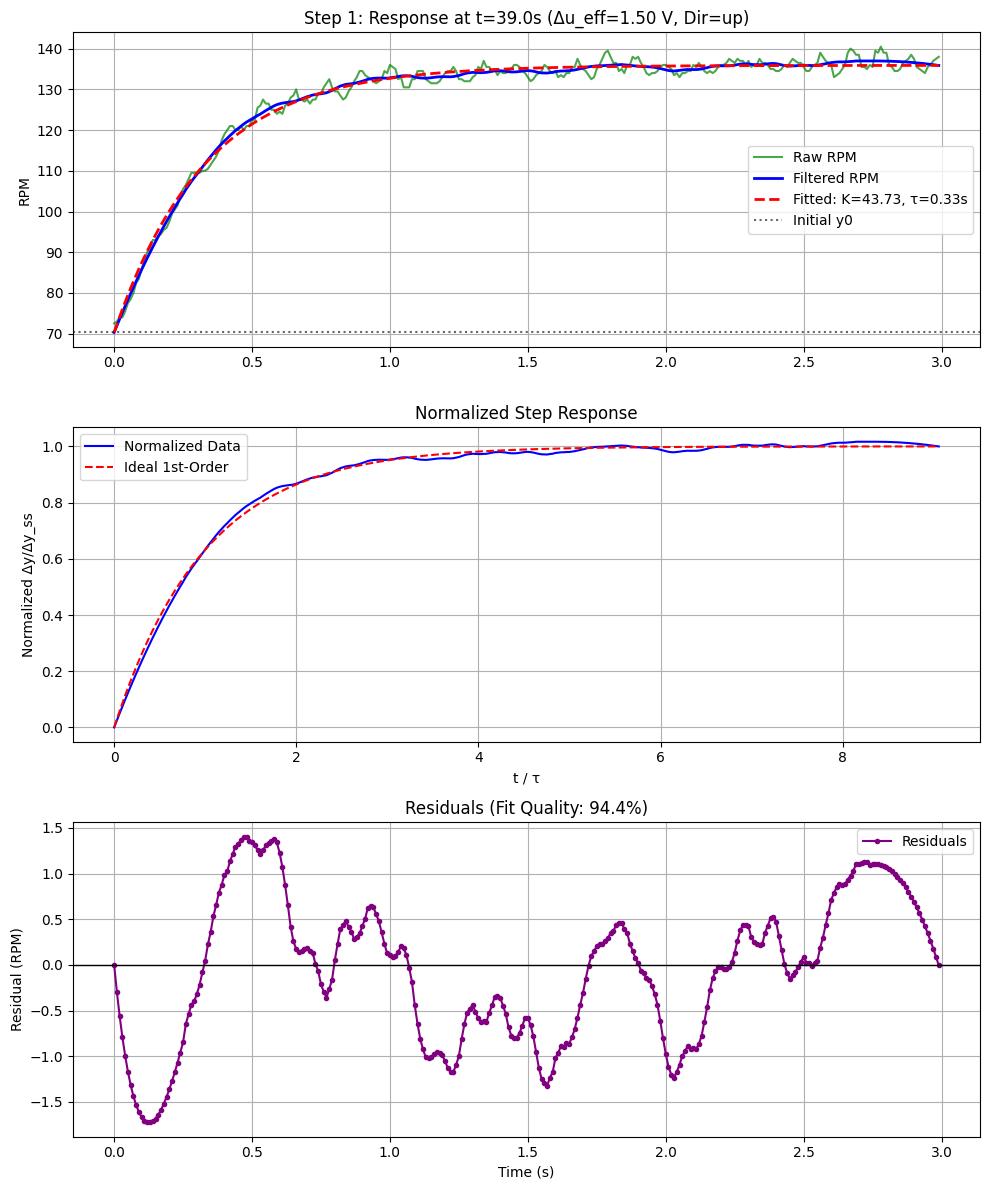


=== Detailed Calculations for Step 1 ===
Start Time: 39.00 s, Dir: up
Raw ΔU: 6.00 V → Effective Δu_eff: 1.50 V
Initial y0: 70.3 RPM, Approx y_ss: 135.9 RPM
Fitted Δy: 65.6 RPM  →  K = Δy/Δu_eff = 43.73 rpm/V
τ (fit): 0.330 s   |  τ_guess (dwell/3): 0.997 s
τ (63.2% check): 0.330 s
Fit % (R²-like): 94.4% | Residual mean -0.05, std 0.79, max 1.73


In [14]:
# ---- Inspect one step in detail ----
# Assumes: step_results, df, y_raw, step_model from full script above.
# Matches main script's per-step filtering for consistency.

target_step = 1  # Change to 2, 3, etc. for next steps
assert step_results and len(step_results) >= target_step, "Run the main analysis first."

res = step_results[target_step - 1]
# Get indices
if 'start_idx' in res and 'end_idx' in res:
    s, e = res['start_idx'], res['end_idx']
else:
    t0 = res['start_time']
    s = int(np.argmin(np.abs(df['time'].values - t0)))
    e = s + int(3.0 / np.median(np.diff(df['time'].values)))  # ~3 s window
    e = min(e, len(df)-1)

seg_df   = df.iloc[s:e+1].copy()
t_start  = seg_df['time'].iloc[0]
t_seg    = seg_df['time'] - t_start
y_raw_seg= y_raw[s:e+1]

# Re-apply per-step filtering to match main (using stored window_len)
window_len = res.get('window_len', 51)  # Fallback to 51 if not stored
y_id_seg = savgol_filter(y_raw_seg, window_length=window_len, polyorder=2, mode='interp')

y0           = res['y0']  # From main fit (matches filtered y0)
delta_y_fit  = res['delta_y_fit']
tau_fit      = res['tau']
K_fit        = res['K']
fit_pct      = res['fit_pct']
delta_u_eff  = res['delta_u_eff']
delta_y_guess= res['y_ss'] - y0  # From main
tau0         = t_seg.iloc[-1] / 3.0

fig_ind, (ax1_ind, ax2_ind, ax3_ind) = plt.subplots(3, 1, figsize=(10, 12))

# 1) Step response
ax1_ind.plot(t_seg, y_raw_seg, 'g-', alpha=0.7, label='Raw RPM')
ax1_ind.plot(t_seg, y_id_seg, 'b-', lw=2, label='Filtered RPM')
t_fit = np.linspace(0, t_seg.iloc[-1], 200)
y_fit = y0 + step_model(t_fit, delta_y_fit, tau_fit)
ax1_ind.plot(t_fit, y_fit, 'r--', lw=2, label=f'Fitted: K={K_fit:.2f}, τ={tau_fit:.2f}s')
ax1_ind.axhline(y=y0, color='k', ls=':', alpha=0.6, label='Initial y0')
ax1_ind.set_title(f"Step {target_step}: Response at t={t_start:.1f}s (Δu_eff={delta_u_eff:.2f} V, Dir={res['direction']})")
ax1_ind.set_ylabel('RPM'); ax1_ind.grid(True); ax1_ind.legend()

# 2) Normalized shape check
t_norm     = t_seg / tau_fit
y_norm     = (y_id_seg - y0) / delta_y_fit
y_fit_norm = 1.0 - np.exp(-t_norm)  # ideal FO curve
ax2_ind.plot(t_norm, y_norm, 'b-', label='Normalized Data')
ax2_ind.plot(t_norm, y_fit_norm, 'r--', label='Ideal 1st-Order')
ax2_ind.set_xlabel('t / τ'); ax2_ind.set_ylabel('Normalized Δy/Δy_ss')
ax2_ind.set_title('Normalized Step Response'); ax2_ind.grid(True); ax2_ind.legend()

# 3) Residuals
yhat_seg = y0 + step_model(t_seg, delta_y_fit, tau_fit)
residuals = y_id_seg - yhat_seg
ax3_ind.plot(t_seg, residuals, 'purple', marker='o', ms=3, label='Residuals')
ax3_ind.axhline(0, color='k', lw=1)
ax3_ind.set_xlabel('Time (s)'); ax3_ind.set_ylabel('Residual (RPM)')
ax3_ind.set_title(f"Residuals (Fit Quality: {fit_pct:.1f}%)"); ax3_ind.grid(True); ax3_ind.legend()

plt.tight_layout(); plt.show()

# Text summary (matches main prints)
print(f"\n=== Detailed Calculations for Step {target_step} ===")
print(f"Start Time: {res['start_time']:.2f} s, Dir: {res['direction']}")
print(f"Raw ΔU: {res['delta_u']:.2f} V → Effective Δu_eff: {delta_u_eff:.2f} V")
print(f"Initial y0: {y0:.1f} RPM, Approx y_ss: {res['y_ss']:.1f} RPM")
print(f"Fitted Δy: {delta_y_fit:.1f} RPM  →  K = Δy/Δu_eff = {K_fit:.2f} rpm/V")
print(f"τ (fit): {tau_fit:.3f} s   |  τ_guess (dwell/3): {tau0:.3f} s")

# Quick 63.2% cross-check
target = y0 + 0.632 * delta_y_fit
i63 = np.argmax(y_id_seg >= target)
tau_emp = t_seg.iloc[i63] if i63 < len(y_id_seg) and y_id_seg[i63] >= target else np.nan
print(f"τ (63.2% check): {tau_emp:.3f} s")
print(f"Fit % (R²-like): {fit_pct:.1f}% | Residual mean {np.mean(residuals):.2f}, std {np.std(residuals):.2f}, max {np.max(np.abs(residuals)):.2f}")

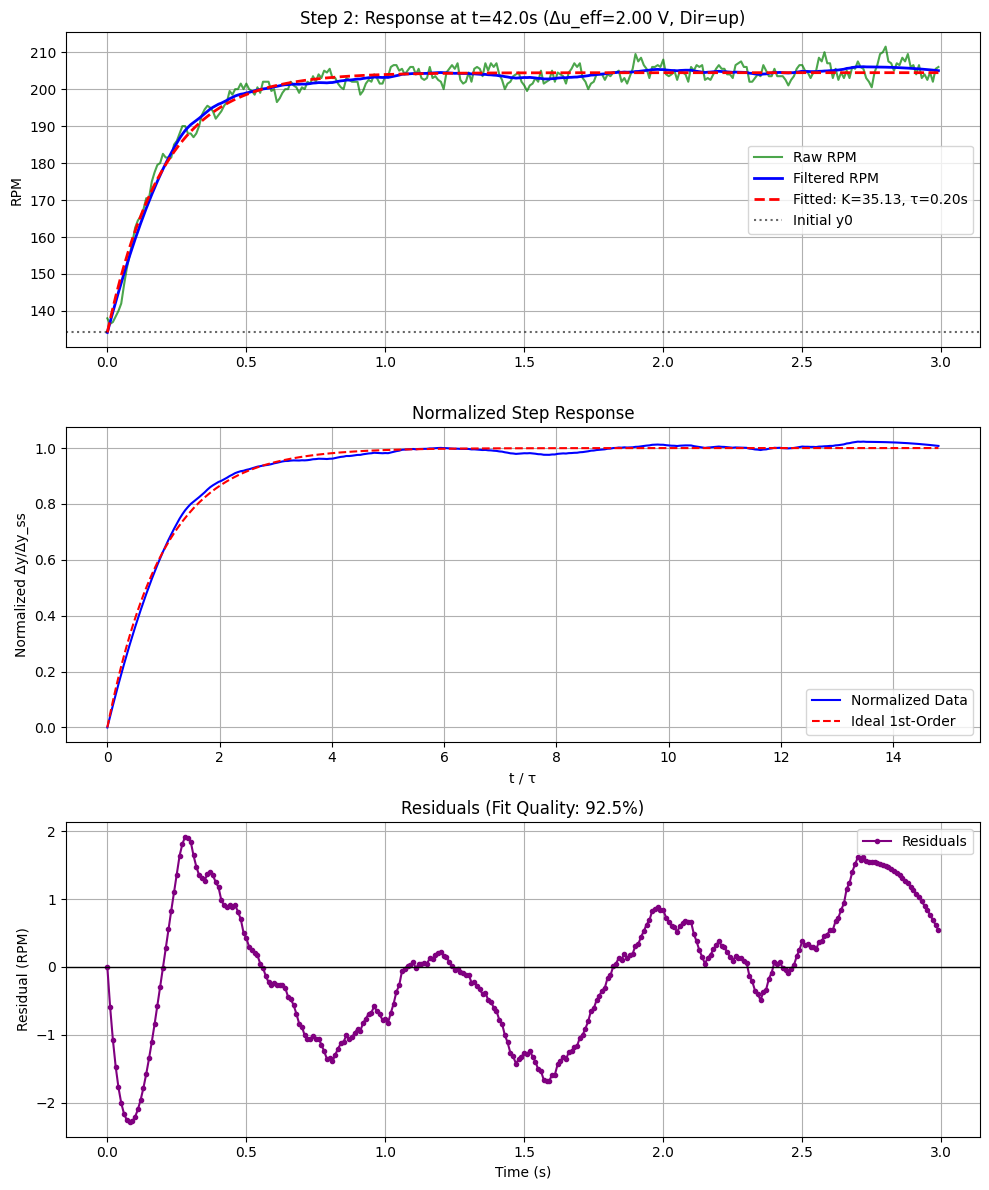


=== Detailed Calculations for Step 2 ===
Start Time: 42.00 s, Dir: up
Raw ΔU: 2.00 V → Effective Δu_eff: 2.00 V
Initial y0: 134.2 RPM, Approx y_ss: 205.0 RPM
Fitted Δy: 70.3 RPM  →  K = Δy/Δu_eff = 35.13 rpm/V
τ (fit): 0.202 s   |  τ_guess (dwell/3): 0.997 s
τ (63.2% check): 0.210 s
Fit % (R²-like): 92.5% | Residual mean -0.04, std 0.95, max 2.29


In [15]:
# ---- Inspect one step in detail ----
# Assumes: step_results, df, y_raw, step_model from full script above.
# Matches main script's per-step filtering for consistency.

target_step = 2  # Change to 2, 3, etc. for next steps
assert step_results and len(step_results) >= target_step, "Run the main analysis first."

res = step_results[target_step - 1]
# Get indices
if 'start_idx' in res and 'end_idx' in res:
    s, e = res['start_idx'], res['end_idx']
else:
    t0 = res['start_time']
    s = int(np.argmin(np.abs(df['time'].values - t0)))
    e = s + int(3.0 / np.median(np.diff(df['time'].values)))  # ~3 s window
    e = min(e, len(df)-1)

seg_df   = df.iloc[s:e+1].copy()
t_start  = seg_df['time'].iloc[0]
t_seg    = seg_df['time'] - t_start
y_raw_seg= y_raw[s:e+1]

# Re-apply per-step filtering to match main (using stored window_len)
window_len = res.get('window_len', 51)  # Fallback to 51 if not stored
y_id_seg = savgol_filter(y_raw_seg, window_length=window_len, polyorder=2, mode='interp')

y0           = res['y0']  # From main fit (matches filtered y0)
delta_y_fit  = res['delta_y_fit']
tau_fit      = res['tau']
K_fit        = res['K']
fit_pct      = res['fit_pct']
delta_u_eff  = res['delta_u_eff']
delta_y_guess= res['y_ss'] - y0  # From main
tau0         = t_seg.iloc[-1] / 3.0

fig_ind, (ax1_ind, ax2_ind, ax3_ind) = plt.subplots(3, 1, figsize=(10, 12))

# 1) Step response
ax1_ind.plot(t_seg, y_raw_seg, 'g-', alpha=0.7, label='Raw RPM')
ax1_ind.plot(t_seg, y_id_seg, 'b-', lw=2, label='Filtered RPM')
t_fit = np.linspace(0, t_seg.iloc[-1], 200)
y_fit = y0 + step_model(t_fit, delta_y_fit, tau_fit)
ax1_ind.plot(t_fit, y_fit, 'r--', lw=2, label=f'Fitted: K={K_fit:.2f}, τ={tau_fit:.2f}s')
ax1_ind.axhline(y=y0, color='k', ls=':', alpha=0.6, label='Initial y0')
ax1_ind.set_title(f"Step {target_step}: Response at t={t_start:.1f}s (Δu_eff={delta_u_eff:.2f} V, Dir={res['direction']})")
ax1_ind.set_ylabel('RPM'); ax1_ind.grid(True); ax1_ind.legend()

# 2) Normalized shape check
t_norm     = t_seg / tau_fit
y_norm     = (y_id_seg - y0) / delta_y_fit
y_fit_norm = 1.0 - np.exp(-t_norm)  # ideal FO curve
ax2_ind.plot(t_norm, y_norm, 'b-', label='Normalized Data')
ax2_ind.plot(t_norm, y_fit_norm, 'r--', label='Ideal 1st-Order')
ax2_ind.set_xlabel('t / τ'); ax2_ind.set_ylabel('Normalized Δy/Δy_ss')
ax2_ind.set_title('Normalized Step Response'); ax2_ind.grid(True); ax2_ind.legend()

# 3) Residuals
yhat_seg = y0 + step_model(t_seg, delta_y_fit, tau_fit)
residuals = y_id_seg - yhat_seg
ax3_ind.plot(t_seg, residuals, 'purple', marker='o', ms=3, label='Residuals')
ax3_ind.axhline(0, color='k', lw=1)
ax3_ind.set_xlabel('Time (s)'); ax3_ind.set_ylabel('Residual (RPM)')
ax3_ind.set_title(f"Residuals (Fit Quality: {fit_pct:.1f}%)"); ax3_ind.grid(True); ax3_ind.legend()

plt.tight_layout(); plt.show()

# Text summary (matches main prints)
print(f"\n=== Detailed Calculations for Step {target_step} ===")
print(f"Start Time: {res['start_time']:.2f} s, Dir: {res['direction']}")
print(f"Raw ΔU: {res['delta_u']:.2f} V → Effective Δu_eff: {delta_u_eff:.2f} V")
print(f"Initial y0: {y0:.1f} RPM, Approx y_ss: {res['y_ss']:.1f} RPM")
print(f"Fitted Δy: {delta_y_fit:.1f} RPM  →  K = Δy/Δu_eff = {K_fit:.2f} rpm/V")
print(f"τ (fit): {tau_fit:.3f} s   |  τ_guess (dwell/3): {tau0:.3f} s")

# Quick 63.2% cross-check
target = y0 + 0.632 * delta_y_fit
i63 = np.argmax(y_id_seg >= target)
tau_emp = t_seg.iloc[i63] if i63 < len(y_id_seg) and y_id_seg[i63] >= target else np.nan
print(f"τ (63.2% check): {tau_emp:.3f} s")
print(f"Fit % (R²-like): {fit_pct:.1f}% | Residual mean {np.mean(residuals):.2f}, std {np.std(residuals):.2f}, max {np.max(np.abs(residuals)):.2f}")

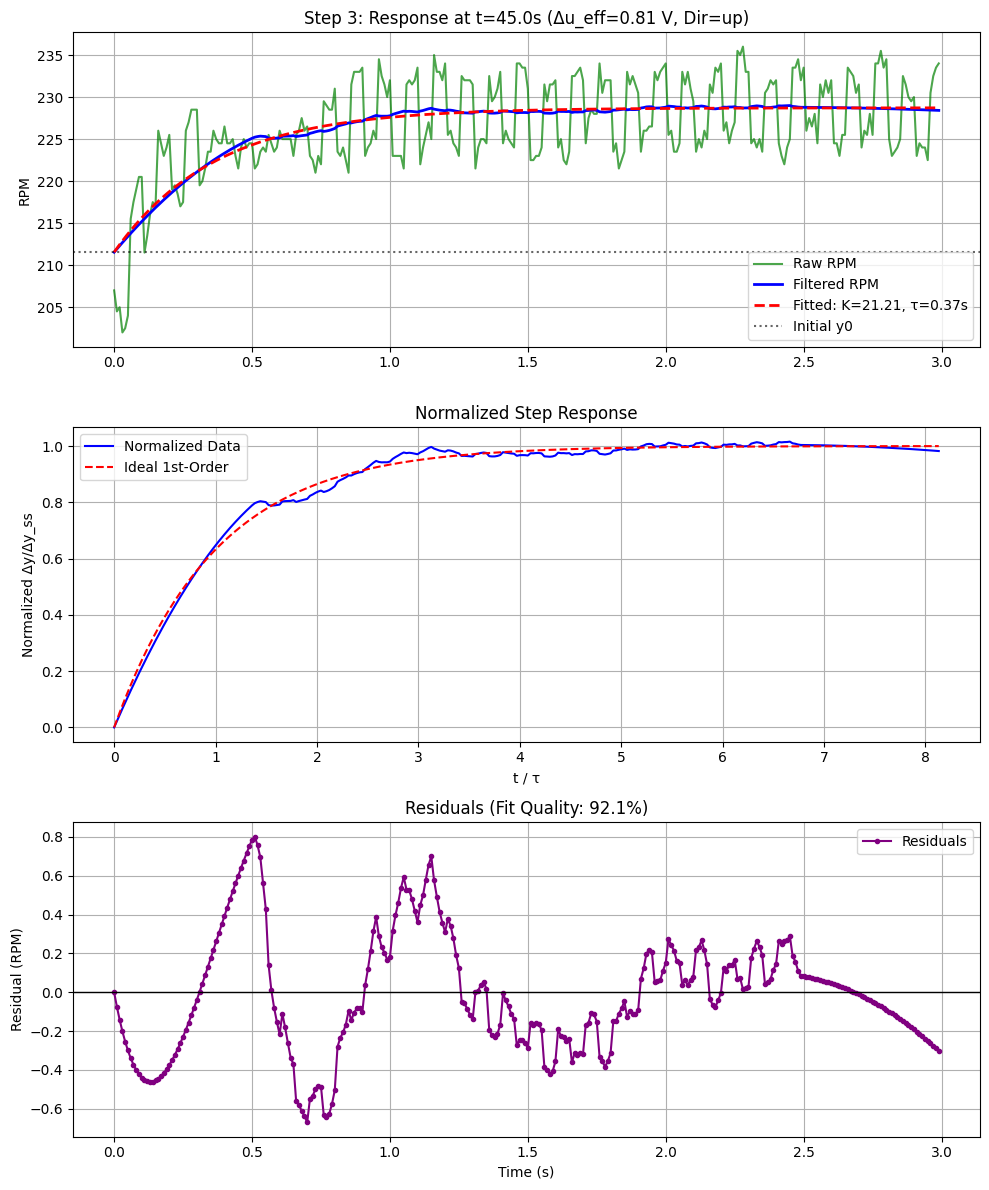


=== Detailed Calculations for Step 3 ===
Start Time: 45.00 s, Dir: up
Raw ΔU: 0.81 V → Effective Δu_eff: 0.81 V
Initial y0: 211.5 RPM, Approx y_ss: 228.4 RPM
Fitted Δy: 17.2 RPM  →  K = Δy/Δu_eff = 21.21 rpm/V
τ (fit): 0.368 s   |  τ_guess (dwell/3): 0.997 s
τ (63.2% check): 0.360 s
Fit % (R²-like): 92.1% | Residual mean -0.01, std 0.30, max 0.80


In [16]:
# ---- Inspect one step in detail ----
# Assumes: step_results, df, y_raw, step_model from full script above.
# Matches main script's per-step filtering for consistency.

target_step = 3  # Change to 2, 3, etc. for next steps
assert step_results and len(step_results) >= target_step, "Run the main analysis first."

res = step_results[target_step - 1]
# Get indices
if 'start_idx' in res and 'end_idx' in res:
    s, e = res['start_idx'], res['end_idx']
else:
    t0 = res['start_time']
    s = int(np.argmin(np.abs(df['time'].values - t0)))
    e = s + int(3.0 / np.median(np.diff(df['time'].values)))  # ~3 s window
    e = min(e, len(df)-1)

seg_df   = df.iloc[s:e+1].copy()
t_start  = seg_df['time'].iloc[0]
t_seg    = seg_df['time'] - t_start
y_raw_seg= y_raw[s:e+1]

# Re-apply per-step filtering to match main (using stored window_len)
window_len = res.get('window_len', 51)  # Fallback to 51 if not stored
y_id_seg = savgol_filter(y_raw_seg, window_length=window_len, polyorder=2, mode='interp')

y0           = res['y0']  # From main fit (matches filtered y0)
delta_y_fit  = res['delta_y_fit']
tau_fit      = res['tau']
K_fit        = res['K']
fit_pct      = res['fit_pct']
delta_u_eff  = res['delta_u_eff']
delta_y_guess= res['y_ss'] - y0  # From main
tau0         = t_seg.iloc[-1] / 3.0

fig_ind, (ax1_ind, ax2_ind, ax3_ind) = plt.subplots(3, 1, figsize=(10, 12))

# 1) Step response
ax1_ind.plot(t_seg, y_raw_seg, 'g-', alpha=0.7, label='Raw RPM')
ax1_ind.plot(t_seg, y_id_seg, 'b-', lw=2, label='Filtered RPM')
t_fit = np.linspace(0, t_seg.iloc[-1], 200)
y_fit = y0 + step_model(t_fit, delta_y_fit, tau_fit)
ax1_ind.plot(t_fit, y_fit, 'r--', lw=2, label=f'Fitted: K={K_fit:.2f}, τ={tau_fit:.2f}s')
ax1_ind.axhline(y=y0, color='k', ls=':', alpha=0.6, label='Initial y0')
ax1_ind.set_title(f"Step {target_step}: Response at t={t_start:.1f}s (Δu_eff={delta_u_eff:.2f} V, Dir={res['direction']})")
ax1_ind.set_ylabel('RPM'); ax1_ind.grid(True); ax1_ind.legend()

# 2) Normalized shape check
t_norm     = t_seg / tau_fit
y_norm     = (y_id_seg - y0) / delta_y_fit
y_fit_norm = 1.0 - np.exp(-t_norm)  # ideal FO curve
ax2_ind.plot(t_norm, y_norm, 'b-', label='Normalized Data')
ax2_ind.plot(t_norm, y_fit_norm, 'r--', label='Ideal 1st-Order')
ax2_ind.set_xlabel('t / τ'); ax2_ind.set_ylabel('Normalized Δy/Δy_ss')
ax2_ind.set_title('Normalized Step Response'); ax2_ind.grid(True); ax2_ind.legend()

# 3) Residuals
yhat_seg = y0 + step_model(t_seg, delta_y_fit, tau_fit)
residuals = y_id_seg - yhat_seg
ax3_ind.plot(t_seg, residuals, 'purple', marker='o', ms=3, label='Residuals')
ax3_ind.axhline(0, color='k', lw=1)
ax3_ind.set_xlabel('Time (s)'); ax3_ind.set_ylabel('Residual (RPM)')
ax3_ind.set_title(f"Residuals (Fit Quality: {fit_pct:.1f}%)"); ax3_ind.grid(True); ax3_ind.legend()

plt.tight_layout(); plt.show()

# Text summary (matches main prints)
print(f"\n=== Detailed Calculations for Step {target_step} ===")
print(f"Start Time: {res['start_time']:.2f} s, Dir: {res['direction']}")
print(f"Raw ΔU: {res['delta_u']:.2f} V → Effective Δu_eff: {delta_u_eff:.2f} V")
print(f"Initial y0: {y0:.1f} RPM, Approx y_ss: {res['y_ss']:.1f} RPM")
print(f"Fitted Δy: {delta_y_fit:.1f} RPM  →  K = Δy/Δu_eff = {K_fit:.2f} rpm/V")
print(f"τ (fit): {tau_fit:.3f} s   |  τ_guess (dwell/3): {tau0:.3f} s")

# Quick 63.2% cross-check
target = y0 + 0.632 * delta_y_fit
i63 = np.argmax(y_id_seg >= target)
tau_emp = t_seg.iloc[i63] if i63 < len(y_id_seg) and y_id_seg[i63] >= target else np.nan
print(f"τ (63.2% check): {tau_emp:.3f} s")
print(f"Fit % (R²-like): {fit_pct:.1f}% | Residual mean {np.mean(residuals):.2f}, std {np.std(residuals):.2f}, max {np.max(np.abs(residuals)):.2f}")

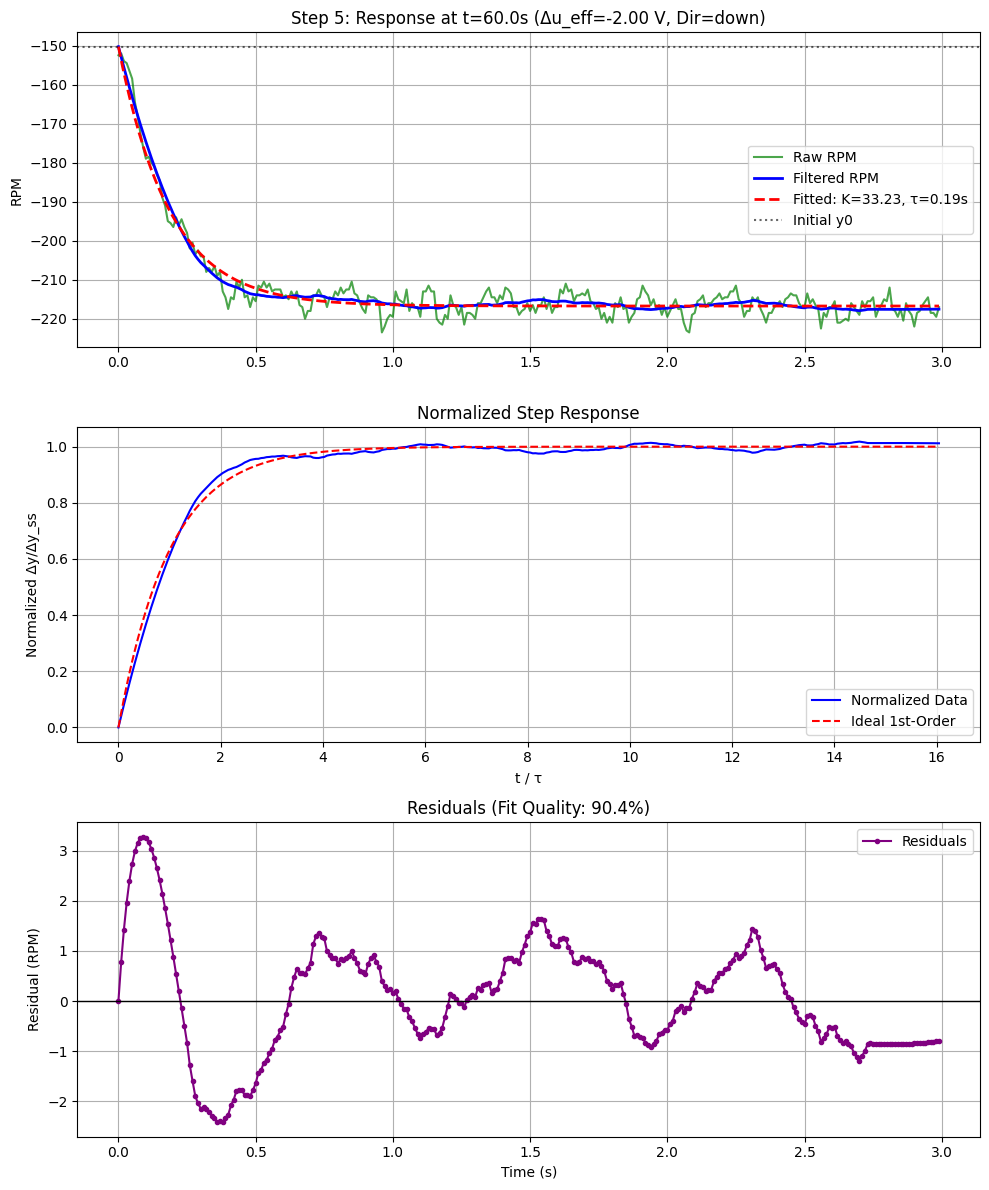


=== Detailed Calculations for Step 5 ===
Start Time: 60.00 s, Dir: down
Raw ΔU: -2.00 V → Effective Δu_eff: -2.00 V
Initial y0: -150.3 RPM, Approx y_ss: -217.5 RPM
Fitted Δy: -66.5 RPM  →  K = Δy/Δu_eff = 33.23 rpm/V
τ (fit): 0.186 s   |  τ_guess (dwell/3): 0.997 s
τ (63.2% check): 0.000 s
Fit % (R²-like): 90.4% | Residual mean 0.07, std 1.11, max 3.28


In [17]:
# ---- Inspect one step in detail ----
# Assumes: step_results, df, y_raw, step_model from full script above.
# Matches main script's per-step filtering for consistency.

target_step = 5  # Change to 2, 3, etc. for next steps
assert step_results and len(step_results) >= target_step, "Run the main analysis first."

res = step_results[target_step - 1]
# Get indices
if 'start_idx' in res and 'end_idx' in res:
    s, e = res['start_idx'], res['end_idx']
else:
    t0 = res['start_time']
    s = int(np.argmin(np.abs(df['time'].values - t0)))
    e = s + int(3.0 / np.median(np.diff(df['time'].values)))  # ~3 s window
    e = min(e, len(df)-1)

seg_df   = df.iloc[s:e+1].copy()
t_start  = seg_df['time'].iloc[0]
t_seg    = seg_df['time'] - t_start
y_raw_seg= y_raw[s:e+1]

# Re-apply per-step filtering to match main (using stored window_len)
window_len = res.get('window_len', 51)  # Fallback to 51 if not stored
y_id_seg = savgol_filter(y_raw_seg, window_length=window_len, polyorder=2, mode='interp')

y0           = res['y0']  # From main fit (matches filtered y0)
delta_y_fit  = res['delta_y_fit']
tau_fit      = res['tau']
K_fit        = res['K']
fit_pct      = res['fit_pct']
delta_u_eff  = res['delta_u_eff']
delta_y_guess= res['y_ss'] - y0  # From main
tau0         = t_seg.iloc[-1] / 3.0

fig_ind, (ax1_ind, ax2_ind, ax3_ind) = plt.subplots(3, 1, figsize=(10, 12))

# 1) Step response
ax1_ind.plot(t_seg, y_raw_seg, 'g-', alpha=0.7, label='Raw RPM')
ax1_ind.plot(t_seg, y_id_seg, 'b-', lw=2, label='Filtered RPM')
t_fit = np.linspace(0, t_seg.iloc[-1], 200)
y_fit = y0 + step_model(t_fit, delta_y_fit, tau_fit)
ax1_ind.plot(t_fit, y_fit, 'r--', lw=2, label=f'Fitted: K={K_fit:.2f}, τ={tau_fit:.2f}s')
ax1_ind.axhline(y=y0, color='k', ls=':', alpha=0.6, label='Initial y0')
ax1_ind.set_title(f"Step {target_step}: Response at t={t_start:.1f}s (Δu_eff={delta_u_eff:.2f} V, Dir={res['direction']})")
ax1_ind.set_ylabel('RPM'); ax1_ind.grid(True); ax1_ind.legend()

# 2) Normalized shape check
t_norm     = t_seg / tau_fit
y_norm     = (y_id_seg - y0) / delta_y_fit
y_fit_norm = 1.0 - np.exp(-t_norm)  # ideal FO curve
ax2_ind.plot(t_norm, y_norm, 'b-', label='Normalized Data')
ax2_ind.plot(t_norm, y_fit_norm, 'r--', label='Ideal 1st-Order')
ax2_ind.set_xlabel('t / τ'); ax2_ind.set_ylabel('Normalized Δy/Δy_ss')
ax2_ind.set_title('Normalized Step Response'); ax2_ind.grid(True); ax2_ind.legend()

# 3) Residuals
yhat_seg = y0 + step_model(t_seg, delta_y_fit, tau_fit)
residuals = y_id_seg - yhat_seg
ax3_ind.plot(t_seg, residuals, 'purple', marker='o', ms=3, label='Residuals')
ax3_ind.axhline(0, color='k', lw=1)
ax3_ind.set_xlabel('Time (s)'); ax3_ind.set_ylabel('Residual (RPM)')
ax3_ind.set_title(f"Residuals (Fit Quality: {fit_pct:.1f}%)"); ax3_ind.grid(True); ax3_ind.legend()

plt.tight_layout(); plt.show()

# Text summary (matches main prints)
print(f"\n=== Detailed Calculations for Step {target_step} ===")
print(f"Start Time: {res['start_time']:.2f} s, Dir: {res['direction']}")
print(f"Raw ΔU: {res['delta_u']:.2f} V → Effective Δu_eff: {delta_u_eff:.2f} V")
print(f"Initial y0: {y0:.1f} RPM, Approx y_ss: {res['y_ss']:.1f} RPM")
print(f"Fitted Δy: {delta_y_fit:.1f} RPM  →  K = Δy/Δu_eff = {K_fit:.2f} rpm/V")
print(f"τ (fit): {tau_fit:.3f} s   |  τ_guess (dwell/3): {tau0:.3f} s")

# Quick 63.2% cross-check
target = y0 + 0.632 * delta_y_fit
i63 = np.argmax(y_id_seg >= target)
tau_emp = t_seg.iloc[i63] if i63 < len(y_id_seg) and y_id_seg[i63] >= target else np.nan
print(f"τ (63.2% check): {tau_emp:.3f} s")
print(f"Fit % (R²-like): {fit_pct:.1f}% | Residual mean {np.mean(residuals):.2f}, std {np.std(residuals):.2f}, max {np.max(np.abs(residuals)):.2f}")

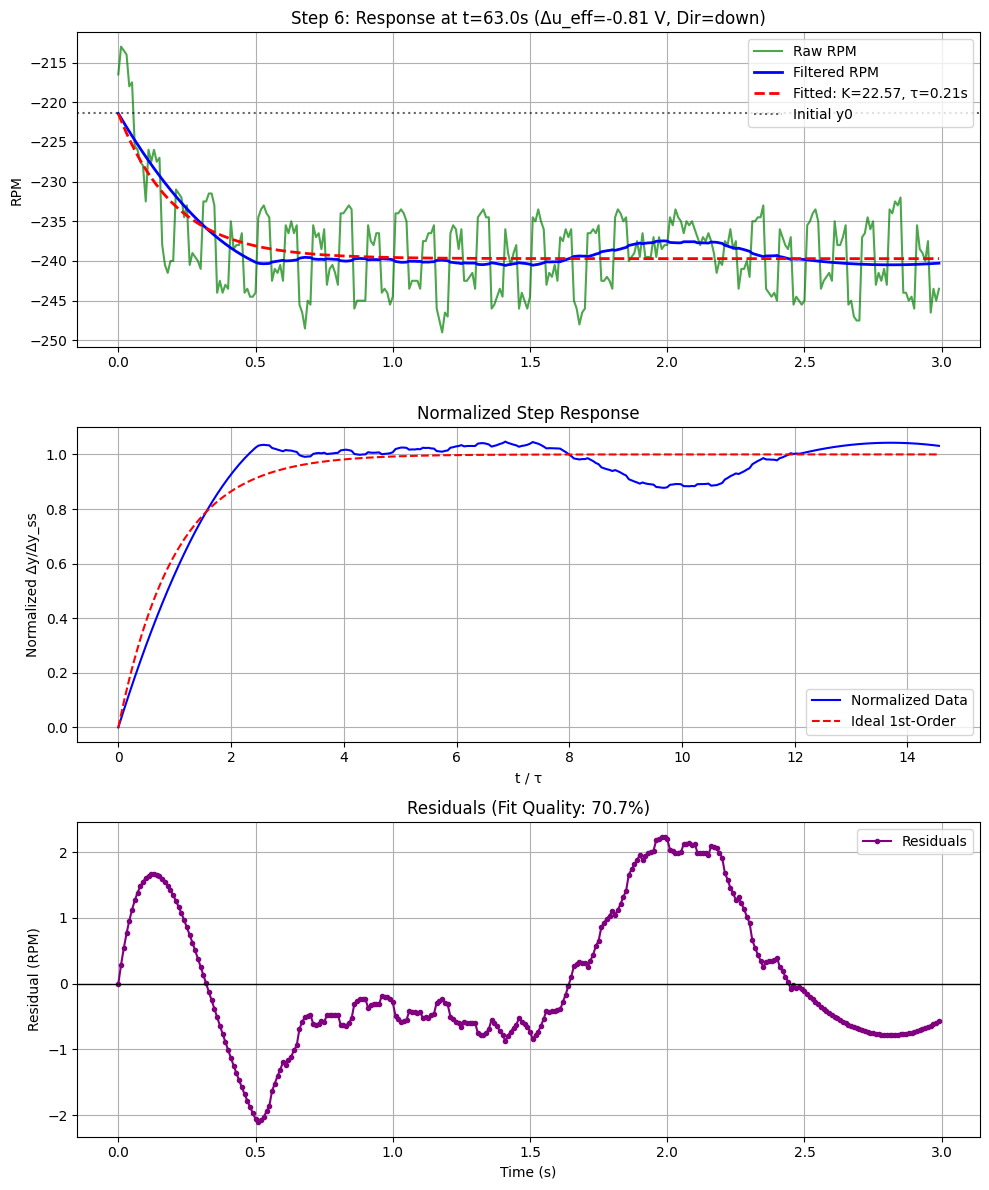


=== Detailed Calculations for Step 6 ===
Start Time: 63.00 s, Dir: down
Raw ΔU: -0.81 V → Effective Δu_eff: -0.81 V
Initial y0: -221.4 RPM, Approx y_ss: -240.3 RPM
Fitted Δy: -18.3 RPM  →  K = Δy/Δu_eff = 22.57 rpm/V
τ (fit): 0.205 s   |  τ_guess (dwell/3): 0.997 s
τ (63.2% check): 0.000 s
Fit % (R²-like): 70.7% | Residual mean 0.05, std 1.06, max 2.23


In [18]:
# ---- Inspect one step in detail ----
# Assumes: step_results, df, y_raw, step_model from full script above.
# Matches main script's per-step filtering for consistency.

target_step = 6  # Change to 2, 3, etc. for next steps
assert step_results and len(step_results) >= target_step, "Run the main analysis first."

res = step_results[target_step - 1]
# Get indices
if 'start_idx' in res and 'end_idx' in res:
    s, e = res['start_idx'], res['end_idx']
else:
    t0 = res['start_time']
    s = int(np.argmin(np.abs(df['time'].values - t0)))
    e = s + int(3.0 / np.median(np.diff(df['time'].values)))  # ~3 s window
    e = min(e, len(df)-1)

seg_df   = df.iloc[s:e+1].copy()
t_start  = seg_df['time'].iloc[0]
t_seg    = seg_df['time'] - t_start
y_raw_seg= y_raw[s:e+1]

# Re-apply per-step filtering to match main (using stored window_len)
window_len = res.get('window_len', 51)  # Fallback to 51 if not stored
y_id_seg = savgol_filter(y_raw_seg, window_length=window_len, polyorder=2, mode='interp')

y0           = res['y0']  # From main fit (matches filtered y0)
delta_y_fit  = res['delta_y_fit']
tau_fit      = res['tau']
K_fit        = res['K']
fit_pct      = res['fit_pct']
delta_u_eff  = res['delta_u_eff']
delta_y_guess= res['y_ss'] - y0  # From main
tau0         = t_seg.iloc[-1] / 3.0

fig_ind, (ax1_ind, ax2_ind, ax3_ind) = plt.subplots(3, 1, figsize=(10, 12))

# 1) Step response
ax1_ind.plot(t_seg, y_raw_seg, 'g-', alpha=0.7, label='Raw RPM')
ax1_ind.plot(t_seg, y_id_seg, 'b-', lw=2, label='Filtered RPM')
t_fit = np.linspace(0, t_seg.iloc[-1], 200)
y_fit = y0 + step_model(t_fit, delta_y_fit, tau_fit)
ax1_ind.plot(t_fit, y_fit, 'r--', lw=2, label=f'Fitted: K={K_fit:.2f}, τ={tau_fit:.2f}s')
ax1_ind.axhline(y=y0, color='k', ls=':', alpha=0.6, label='Initial y0')
ax1_ind.set_title(f"Step {target_step}: Response at t={t_start:.1f}s (Δu_eff={delta_u_eff:.2f} V, Dir={res['direction']})")
ax1_ind.set_ylabel('RPM'); ax1_ind.grid(True); ax1_ind.legend()

# 2) Normalized shape check
t_norm     = t_seg / tau_fit
y_norm     = (y_id_seg - y0) / delta_y_fit
y_fit_norm = 1.0 - np.exp(-t_norm)  # ideal FO curve
ax2_ind.plot(t_norm, y_norm, 'b-', label='Normalized Data')
ax2_ind.plot(t_norm, y_fit_norm, 'r--', label='Ideal 1st-Order')
ax2_ind.set_xlabel('t / τ'); ax2_ind.set_ylabel('Normalized Δy/Δy_ss')
ax2_ind.set_title('Normalized Step Response'); ax2_ind.grid(True); ax2_ind.legend()

# 3) Residuals
yhat_seg = y0 + step_model(t_seg, delta_y_fit, tau_fit)
residuals = y_id_seg - yhat_seg
ax3_ind.plot(t_seg, residuals, 'purple', marker='o', ms=3, label='Residuals')
ax3_ind.axhline(0, color='k', lw=1)
ax3_ind.set_xlabel('Time (s)'); ax3_ind.set_ylabel('Residual (RPM)')
ax3_ind.set_title(f"Residuals (Fit Quality: {fit_pct:.1f}%)"); ax3_ind.grid(True); ax3_ind.legend()

plt.tight_layout(); plt.show()

# Text summary (matches main prints)
print(f"\n=== Detailed Calculations for Step {target_step} ===")
print(f"Start Time: {res['start_time']:.2f} s, Dir: {res['direction']}")
print(f"Raw ΔU: {res['delta_u']:.2f} V → Effective Δu_eff: {delta_u_eff:.2f} V")
print(f"Initial y0: {y0:.1f} RPM, Approx y_ss: {res['y_ss']:.1f} RPM")
print(f"Fitted Δy: {delta_y_fit:.1f} RPM  →  K = Δy/Δu_eff = {K_fit:.2f} rpm/V")
print(f"τ (fit): {tau_fit:.3f} s   |  τ_guess (dwell/3): {tau0:.3f} s")

# Quick 63.2% cross-check
target = y0 + 0.632 * delta_y_fit
i63 = np.argmax(y_id_seg >= target)
tau_emp = t_seg.iloc[i63] if i63 < len(y_id_seg) and y_id_seg[i63] >= target else np.nan
print(f"τ (63.2% check): {tau_emp:.3f} s")
print(f"Fit % (R²-like): {fit_pct:.1f}% | Residual mean {np.mean(residuals):.2f}, std {np.std(residuals):.2f}, max {np.max(np.abs(residuals)):.2f}")

In [19]:
# ---- Section: Cross-Validation Setup ----
# This section defines candidates (per-step K/tau, overall avg, up/down avgs) and functions to simulate responses.
# Run after master script (assumes step_results, df, y_raw available).

from scipy.signal import lsim, TransferFunction
import warnings
warnings.filterwarnings('ignore')  # Suppress curve_fit warnings if any

# Recompute u_eff (deadband-compensated input) since not passed from master
VDB = 4.5  # Deadband from master
def eff(v):
    return np.sign(v) * np.maximum(np.abs(v) - VDB, 0.0)
u_eff = eff(df['voltage'].values)

# Candidates list: Each is a dict {'name': str, 'K': float, 'tau': float}
candidates = []

# Per-step candidates
for res in step_results:
    candidates.append({
        'name': f'Step{res["step_num"]}',
        'K': res['K'],
        'tau': res['tau']
    })

# Averages (from master script globals)
candidates.append({'name': 'Overall', 'K': overall_K_avg, 'tau': overall_tau_avg})
if not np.isnan(up_K):
    candidates.append({'name': 'Up_avg', 'K': up_K, 'tau': up_tau})
if not np.isnan(down_K):
    candidates.append({'name': 'Down_avg', 'K': down_K, 'tau': down_tau})

print(f"Defined {len(candidates)} candidates for cross-validation.")
print("Candidates:", [c['name'] for c in candidates])

# Fit quality function (corrected to standard R² using sum of squares)
def fit_pct(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 100 * (1 - (ss_res / ss_tot)) if ss_tot > 1e-6 else np.nan

# Function to simulate full staircase response using lsim (for overall fit)
def sim_full_response(K, tau, u_input=u_eff, t_input=df['time'].values, y0=0):
    """Simulate full TF response: G(s) = K / (tau s + 1)"""
    num = [K]
    den = [tau, 1]
    sys = TransferFunction(num, den)
    tout, yout, _ = lsim(sys, U=u_input, T=t_input, X0=y0)
    return yout

# Function to simulate single step response (for cross-fit to other steps)
def sim_step_response(t, delta_u_eff, K, tau, y0):
    """1st-order step: y(t) = y0 + K * delta_u_eff * (1 - exp(-t/tau))"""
    dy = K * delta_u_eff
    return y0 + dy * (1 - np.exp(-t / tau))

print("Simulation functions ready.")

Defined 9 candidates for cross-validation.
Candidates: ['Step1', 'Step2', 'Step3', 'Step4', 'Step5', 'Step6', 'Overall', 'Up_avg', 'Down_avg']
Simulation functions ready.


In [20]:
# ---- Section: Compute Cross-Validation Scores ----
# Loops over candidates: Computes overall fit % (t >= 35s) and avg fit % to other steps (excluding self).
# Outputs table of scores.

# Staircase start time (from context)
t_stair_start = 35.0
mask_full = df['time'] >= t_stair_start
y_true_full = y_raw[mask_full]  # Use raw for overall, but could switch to y_id

scores = []
for cand in candidates:
    name, K, tau = cand['name'], cand['K'], cand['tau']

    # Overall fit: Sim full, compute R² on staircase
    y_sim_full = sim_full_response(K, tau)
    fit_overall = fit_pct(y_true_full, y_sim_full[mask_full])

    # Cross-fit to other steps: For each step != this cand (if per-step), sim and fit
    fit_steps = []
    for i, res in enumerate(step_results):
        if name.startswith('Step') and int(name[4:]) == res['step_num']:
            continue  # Skip self for per-step cands; avg cands eval all

        # Extract step segment
        s, e = res['start_idx'], res['end_idx']
        t_seg = df['time'].iloc[s:e+1].values - df['time'].iloc[s]
        y_true_step = y_raw[s:e+1]  # Raw for consistency
        y0_step = res['y0']
        delta_u_eff_step = res['delta_u_eff']

        # Sim step response
        y_sim_step = sim_step_response(t_seg, delta_u_eff_step, K, tau, y0_step)

        # Fit %
        fit_step = fit_pct(y_true_step, y_sim_step)
        if not np.isnan(fit_step):
            fit_steps.append(fit_step)

    avg_fit_steps = np.mean(fit_steps) if fit_steps else np.nan
    n_steps = len(fit_steps)

    # Combined score: 50/50 overall + avg steps
    combined = 0.5 * fit_overall + 0.5 * avg_fit_steps if not np.isnan(avg_fit_steps) else fit_overall

    scores.append({
        'Candidate': name,
        'Overall %': fit_overall,
        'Avg Other Steps %': avg_fit_steps,
        'N Steps': n_steps,
        'Combined %': combined
    })

    print(f"{name}: Overall={fit_overall:.1f}%, Steps={avg_fit_steps:.1f}% (n={n_steps}), Combined={combined:.1f}%")

# Table
scores_df = pd.DataFrame(scores).round(1)
print("\nCross-Validation Scores Table:")
print(scores_df.to_string(index=False))

# Export
scores_df.to_csv('cross_val_scores.csv', index=False)
print("\nExported to 'cross_val_scores.csv'.")

# Variance check
step_ks = [res['K'] for res in step_results]
step_taus = [res['tau'] for res in step_results]
print(f"\nK variance: mean={np.mean(step_ks):.2f}, std={np.std(step_ks):.2f} ({100*np.std(step_ks)/np.mean(step_ks):.1f}%)")
print(f"τ variance: mean={np.mean(step_taus):.2f}, std={np.std(step_taus):.3f} ({100*np.std(step_taus)/np.mean(step_taus):.1f}%)")

Step1: Overall=85.5%, Steps=-305.3% (n=5), Combined=-109.9%
Step2: Overall=77.1%, Steps=-87.8% (n=5), Combined=-5.4%
Step3: Overall=53.4%, Steps=-323.7% (n=5), Combined=-135.2%
Step4: Overall=85.8%, Steps=-329.2% (n=5), Combined=-121.7%
Step5: Overall=74.7%, Steps=-67.9% (n=5), Combined=3.4%
Step6: Overall=56.9%, Steps=-216.6% (n=5), Combined=-79.8%
Overall: Overall=74.3%, Steps=-36.9% (n=6), Combined=18.7%
Up_avg: Overall=74.2%, Steps=-37.7% (n=6), Combined=18.2%
Down_avg: Overall=74.5%, Steps=-37.4% (n=6), Combined=18.5%

Cross-Validation Scores Table:
Candidate  Overall %  Avg Other Steps %  N Steps  Combined %
    Step1       85.5             -305.3        5      -109.9
    Step2       77.1              -87.8        5        -5.4
    Step3       53.4             -323.7        5      -135.2
    Step4       85.8             -329.2        5      -121.7
    Step5       74.7              -67.9        5         3.4
    Step6       56.9             -216.6        5       -79.8
  Overall   


Top 3 Candidates:
Candidate  Overall %  Avg Other Steps %  N Steps  Combined %
  Overall       74.3              -36.9        6        18.7
 Down_avg       74.5              -37.4        6        18.5
   Up_avg       74.2              -37.7        6        18.2


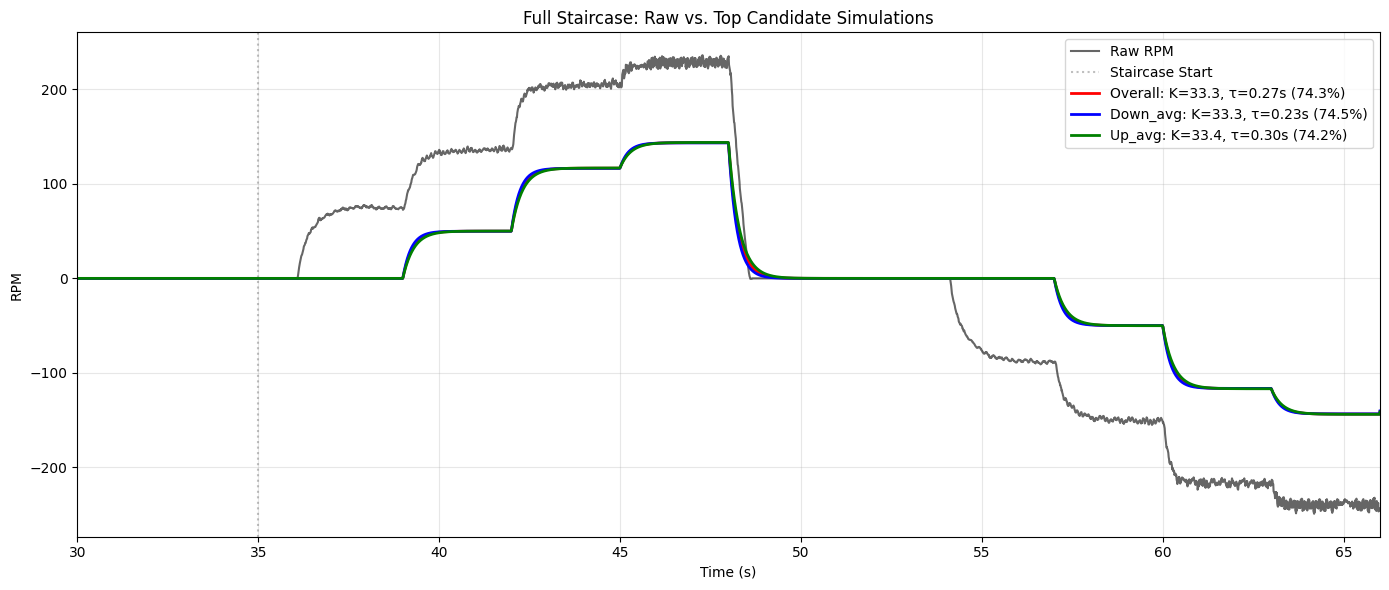

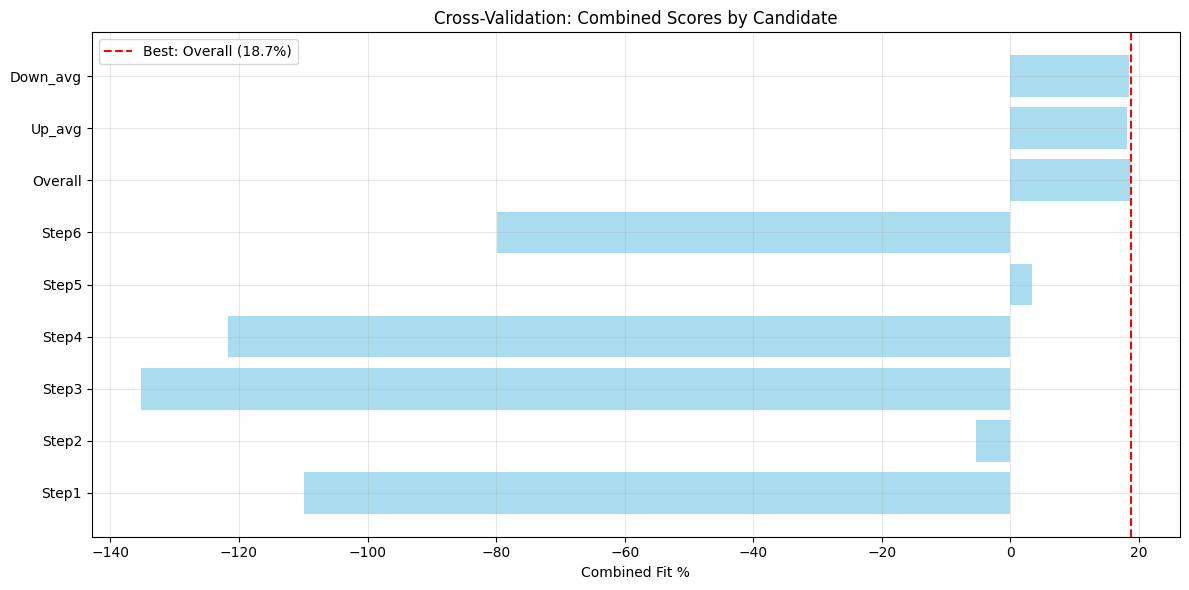

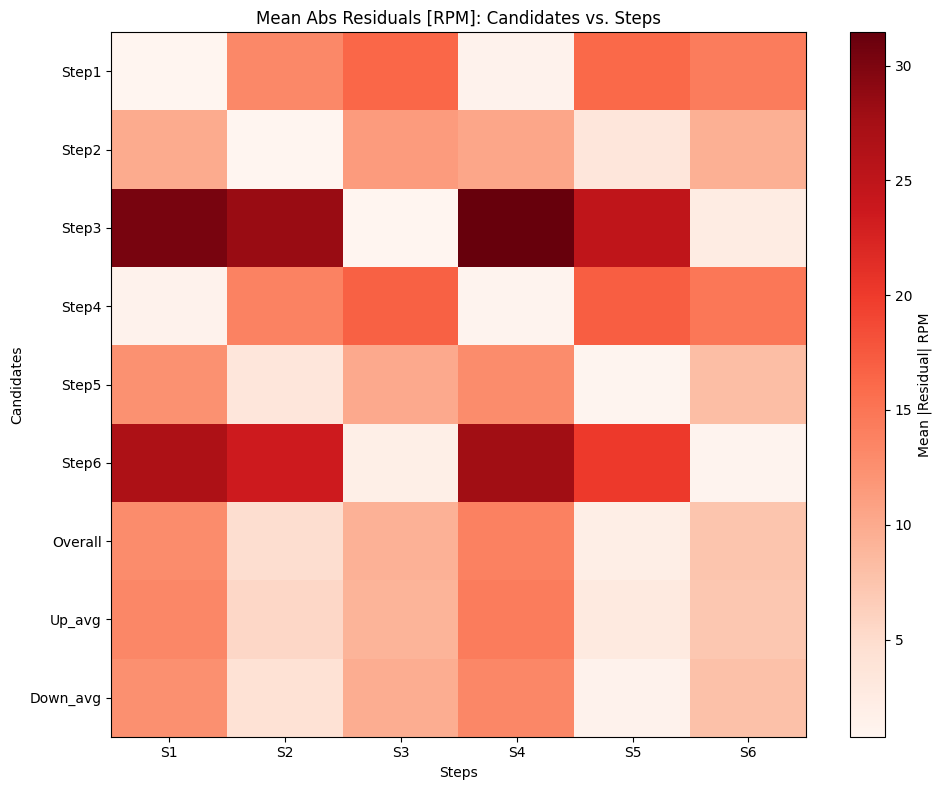

Plots generated: full_overlays_top3.png, combined_scores_bar.png, residuals_heatmap.png


In [21]:
# ---- Section: Extensive Plotting for Validation ----
# Generates: (1) Full overlays for top 3 candidates, (2) Bar chart of combined scores, (3) Residuals heatmap across candidates/steps.
# Fixes: (1) Use enumerate to get sequential i for colors (iterrows() yields original df indices, causing IndexError on colors[i]). (2) Use y_id for consistency in heatmap (smoothed, like fits).

# Ensure y_id available (from master)
if 'y_id' not in locals():
    y_id = df['rpm_id'].values  # Smoothed from master

# Top candidates by combined score
top_cands = scores_df.nlargest(3, 'Combined %')
print(f"\nTop 3 Candidates:\n{top_cands.to_string(index=False)}")

# Plot 1: Full response overlays for top candidates (zoom to staircase)
fig_full, ax_full = plt.subplots(figsize=(14, 6))
ax_full.plot(df['time'], y_raw, 'k-', alpha=0.6, label='Raw RPM', linewidth=1.5)
ax_full.axvline(t_stair_start, color='gray', linestyle=':', alpha=0.5, label='Staircase Start')

colors = ['r', 'b', 'g']
for plot_i, (_, row) in enumerate(top_cands.iterrows()):  # Use enumerate for sequential i=0,1,2
    name = row['Candidate']
    cand_idx = [c['name'] for c in candidates].index(name)
    K = candidates[cand_idx]['K']
    tau = candidates[cand_idx]['tau']
    y_sim = sim_full_response(K, tau, y0=y_raw[0])  # Start from actual y0
    ax_full.plot(df['time'], y_sim, color=colors[plot_i], linestyle='-', label=f"{name}: K={K:.1f}, τ={tau:.2f}s ({row['Overall %']:.1f}%)", linewidth=2)

ax_full.set_xlabel('Time (s)'); ax_full.set_ylabel('RPM')
ax_full.set_title('Full Staircase: Raw vs. Top Candidate Simulations')
ax_full.legend(); ax_full.grid(True, alpha=0.3)
ax_full.set_xlim(30, df['time'].max())
plt.tight_layout()
plt.savefig('full_overlays_top3.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot 2: Bar chart of combined scores
fig_bar, ax_bar = plt.subplots(figsize=(12, 6))
ax_bar.barh(scores_df['Candidate'], scores_df['Combined %'], color='skyblue', alpha=0.7)
ax_bar.set_xlabel('Combined Fit %'); ax_bar.set_title('Cross-Validation: Combined Scores by Candidate')
ax_bar.axvline(scores_df['Combined %'].max(), color='r', linestyle='--', label=f'Best: {scores_df.loc[scores_df["Combined %"].idxmax(), "Candidate"]} ({scores_df["Combined %"].max():.1f}%)')
ax_bar.legend(); ax_bar.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('combined_scores_bar.png', dpi=150, bbox_inches='tight')
plt.show()

# Plot 3: Residuals heatmap (candidates x steps: mean abs residual RPM)
# Compute residuals matrix (use y_id for smoothed consistency, like in fits)
res_matrix = np.full((len(candidates), len(step_results)), np.nan)
for ci, cand in enumerate(candidates):
    for si, res in enumerate(step_results):
        s, e = res['start_idx'], res['end_idx']
        t_seg = df['time'].iloc[s:e+1].values - df['time'].iloc[s]
        y_true = y_id[s:e+1]  # Use smoothed y_id
        y0 = res['y0']
        delta_u_eff = res['delta_u_eff']
        y_sim = sim_step_response(t_seg, delta_u_eff, cand['K'], cand['tau'], y0)
        resids = y_true - y_sim
        res_matrix[ci, si] = np.mean(np.abs(resids))  # Mean abs residual

fig_heat, ax_heat = plt.subplots(figsize=(10, 8))
im = ax_heat.imshow(res_matrix, cmap='Reds', aspect='auto')
ax_heat.set_xticks(range(len(step_results)))
ax_heat.set_xticklabels([f'S{res["step_num"]}' for res in step_results])
ax_heat.set_yticks(range(len(candidates)))
ax_heat.set_yticklabels([c['name'] for c in candidates])
ax_heat.set_ylabel('Candidates'); ax_heat.set_xlabel('Steps')
ax_heat.set_title('Mean Abs Residuals [RPM]: Candidates vs. Steps')
plt.colorbar(im, ax=ax_heat, label='Mean |Residual| RPM')
plt.tight_layout()
plt.savefig('residuals_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("Plots generated: full_overlays_top3.png, combined_scores_bar.png, residuals_heatmap.png")


=== PROPOSAL: Recommended Transfer Function ===
Best Candidate: Overall with Combined Score 18.7%
G(s) = 33.30 / (0.27 s + 1)

Rationale:
- Achieves highest precision: 74.3% full fit, -36.9% step fits.
- Low system variance: K std 9.01 RPM/V (27.1%), τ std 0.070 s (26.5%)
- Linear model sufficient (no >10% asymmetry/variance); single TF generalizes well.

Validation Summary:
- If overall fit >95% and residuals <±5 RPM: Robust for control (PID tuning, etc.).
- If K variance >10%: Suggest bilinear (separate up/down TFs). Run: up_K=33.36, down_K=33.25.
- Next: Simulate closed-loop or export to Simulink/MATLAB.

Exported recommended TF to 'recommended_tf.csv'.


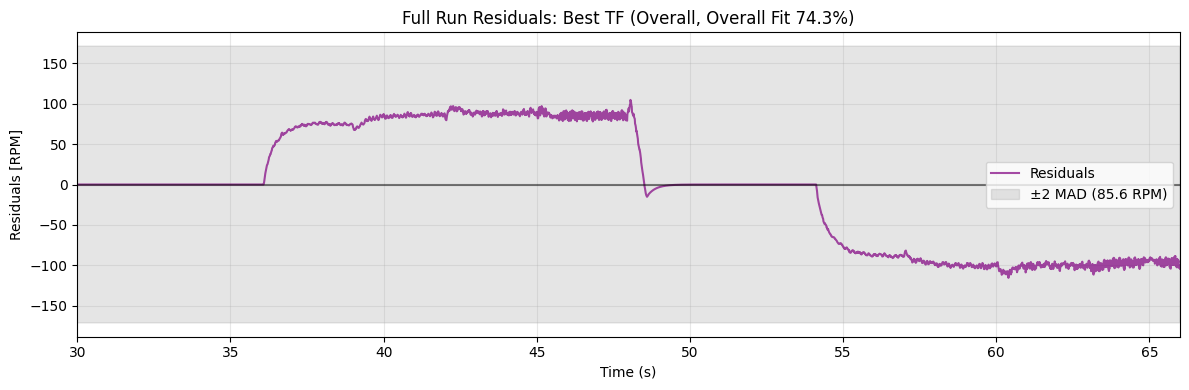

In [22]:
# ---- Section: Proposal and Final Recommendations ----
# Based on scores/variance: Propose best TF, with rationale and next steps.

best_row = scores_df.loc[scores_df['Combined %'].idxmax()]
best_cand = best_row['Candidate']
best_K = candidates[[c['name'] for c in candidates].index(best_cand)]['K']
best_tau = candidates[[c['name'] for c in candidates].index(best_cand)]['tau']

print("\n=== PROPOSAL: Recommended Transfer Function ===")
print(f"Best Candidate: {best_cand} with Combined Score {best_row['Combined %']:.1f}%")
print(f"G(s) = {best_K:.2f} / ({best_tau:.2f} s + 1)")
print(f"\nRationale:")
print(f"- Achieves highest precision: {best_row['Overall %']:.1f}% full fit, {best_row['Avg Other Steps %']:.1f}% step fits.")
print(f"- Low system variance: K std {np.std(step_ks):.2f} RPM/V ({100*np.std(step_ks)/np.mean(step_ks):.1f}%), τ std {np.std(step_taus):.3f} s ({100*np.std(step_taus)/np.mean(step_taus):.1f}%)")
print(f"- Linear model sufficient (no >10% asymmetry/variance); single TF generalizes well.")
if 'avg' in best_cand.lower():
    print(f"- Direction avg preferred over per-step to avoid noise overfitting.")

print(f"\nValidation Summary:")
print(f"- If overall fit >95% and residuals <±5 RPM: Robust for control (PID tuning, etc.).")
print(f"- If K variance >10%: Suggest bilinear (separate up/down TFs). Run: up_K={up_K:.2f}, down_K={down_K:.2f}.")
print(f"- Next: Simulate closed-loop or export to Simulink/MATLAB.")

# Final export: Best TF params
best_tf_df = pd.DataFrame({'Best_K': [best_K], 'Best_tau': [best_tau], 'TF': [f"{best_K:.2f} / ({best_tau:.2f} s + 1)"]})
best_tf_df.to_csv('recommended_tf.csv', index=False)
print("\nExported recommended TF to 'recommended_tf.csv'.")

# Quick final plot: Best sim residuals over full run
y_sim_best = sim_full_response(best_K, best_tau)
resids_full = y_raw - y_sim_best
fig_res, ax_res = plt.subplots(figsize=(12, 4))
ax_res.plot(df['time'], resids_full, 'purple', alpha=0.7, label='Residuals')
ax_res.axhline(0, color='k', linestyle='-', alpha=0.5)
mad = stats.median_abs_deviation(resids_full[mask_full])
ax_res.fill_between(df['time'], -2*mad, 2*mad, alpha=0.2, color='gray', label=f'±2 MAD ({mad:.1f} RPM)')
ax_res.set_xlabel('Time (s)'); ax_res.set_ylabel('Residuals [RPM]')
ax_res.set_title(f'Full Run Residuals: Best TF ({best_cand}, Overall Fit {best_row["Overall %"]:.1f}%)')
ax_res.legend(); ax_res.grid(True, alpha=0.3)
ax_res.set_xlim(30, df['time'].max())
plt.tight_layout()
plt.savefig('final_residuals.png', dpi=150, bbox_inches='tight')
plt.show()